# 電波ポインティング解析

## 初期処理
- 以下の定数 (大文字の変数名のもの) を各自で設定すること
  - `sys.path` の操作については PyPl ではなくローカルのパッケージを使いたい時に使用すること

In [79]:
# ======================================================================
DATETIME = "20240905_060249"  # データファイル名の日時部分 "YYYYMMDD_HHMMSS"
# ======================================================================
PLANET = "sun"  # 観測対象  e.g. "sun", "moon"
RAWDATA_PATH = f"./necst_radiopointing_{DATETIME}_{PLANET}"  # 観測データのパス
SPECTRAL_NAME = "necst-OMU1P85M-data-spectral-None-board2"  # 解析に使用する分光データのファイル名
SAVE_PATH = f"./{DATETIME}_{PLANET}"  # 解析結果の保存先

PATH_NERCST = "/Users/kirby/GitHub/nercst"
PATH_NECLIB = "/Users/kirby/GitHub/neclib"
# ======================================================================
import pprint
import sys

if PATH_NERCST not in sys.path:
    sys.path.insert(0, PATH_NERCST)
if PATH_NECLIB not in sys.path:
    sys.path.insert(0, PATH_NECLIB)
pprint.pprint(sys.path)
# ======================================================================

['/Users/kirby/GitHub/neclib',
 '/Users/kirby/GitHub/nercst',
 '/Users/kirby/.pyenv/versions/3.9.18/lib/python39.zip',
 '/Users/kirby/.pyenv/versions/3.9.18/lib/python3.9',
 '/Users/kirby/.pyenv/versions/3.9.18/lib/python3.9/lib-dynload',
 '',
 '/Users/kirby/Library/CloudStorage/GoogleDrive-ryo106.n67@gmail.com/その他のパソコン/マイ '
 'ノートパソコン/Astro/NECST/sunscan/.venv/lib/python3.9/site-packages']


- 以降は設定不要

In [80]:
%matplotlib inline
import bisect
import math
from typing import List, Literal, Tuple

import nercst
import os
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
from astropy.convolution import Box1DKernel, convolve
from scipy import optimize
from scipy.optimize import curve_fit

from astropy.time import Time
from astropy.coordinates import get_body, AltAz
from astropy import units as u
from neclib.coordinates import PointingError

from neclib import config
from neclib.core import Parameters

In [81]:
print(nercst.__path__)
import neclib
print(neclib.__path__)

['/Users/kirby/GitHub/nercst/nercst']
['/Users/kirby/GitHub/neclib/neclib']


In [82]:
def gaussian_func(x, a, mu, sigma):
    """ガウス関数

    Parameters
    ----------
    x
        x座標。
    a
        振幅。
    mu
        中心位置を示す値。
    sigma
        標準偏差。
    """
    return a * np.exp(- (x - mu) ** 2 / (2 * sigma ** 2))

def find_nearest_index(lst: List[float], target: float) -> int:
    """
    昇順に並んだ数値のリストの中で指定された数値に最も近い要素のインデックスを返す。
    
    Parameters
    ----------
    lst
        昇順に並んだ数値のリスト。
    target
        対象となる数値。この数値に最も近いリスト内の要素のインデックスを探す。
        
    Returns
    -------
    int
        `target`に最も近い要素のインデックス。
    
    Example
    -------
    >>> l = [0.5, 1.2, 3.4, 7.6, 8.9]
    >>> find_nearest_index(l, 3.1)
    2
    """
    pos = bisect.bisect_left(lst, target)
    
    if pos == 0:
        return 0
    if pos == len(lst):
        return len(lst) - 1
    
    before = pos - 1
    after = pos
    if abs(lst[after] - target) < abs(lst[before] - target):
        return after
    else:
        return before

def make_id_index(data) -> List[List[List[int]]]:
    id_index = []
    _id_index = []
    __id_index = []
    prev_cross = 0
    prev_axis = 0
    id_values = data.id.values
    # id_values = np.append(id.values, b"9999")  # 末尾のスキャンを処理するためのダミーが必要だが、既にIDデータ配列の末尾に9999が含まれているため不要

    for i, _x in enumerate(id_values):
        x = _x.decode().strip()
        if x == "":
            continue

        if "-" not in x:  # x: 9999 (final hot and off)
            _id_index.append(__id_index)
            id_index.append(_id_index)
            break

        if int(x[-1]) != prev_axis:  # axis: 0 (Az) or 1 (El)
            _id_index.append(__id_index)
            __id_index = []

        if int(x[:-2]) != prev_cross:  # cross_id: 0, 1, 2, ..., n-1
            id_index.append(_id_index)
            _id_index = []

        __id_index.append(i)
        prev_cross = int(x[:-2])
        prev_axis = int(x[-1])
    
    return id_index

def get_scan_range(cross_id: int, axis: int) -> Tuple[int, int, int]:
    """指定されたスキャンの始点、中点、終点のインデックスを順に返す。"""
    id_index = make_id_index(data)
    end = id_index[cross_id][axis][-1]
    scan_start_time = data.t[end] - one_scan_time.to(u.s).value
    scan_center_time = data.t[end] - one_scan_time.to(u.s).value / 2
    finded_start = find_nearest_index(data.t, scan_start_time)
    if finded_start >= id_index[cross_id][axis][0]:
        start = finded_start
        center = find_nearest_index(data.t, scan_center_time)
    else:
        # 推定されるスキャンの始点が見つからなかった場合、スキャンが中断された可能性がある
        start = id_index[cross_id][axis][0]
        center = (start + end) // 2
    return start, center, end

In [83]:
# パスの設定
rawdata_path = Path(RAWDATA_PATH)
spectral_name = Path(SPECTRAL_NAME)
save_path = Path(SAVE_PATH)

# 観測指示書の検索、読み込み、コピー
impl = rawdata_path.glob("*.toml")
for p in impl:
    if p.name not in ["config.toml", "pointing_param.toml"]:
        print(f"{p.name!r} was found as the observation instruction file.")
        obs_param = Parameters.from_file(rawdata_path / p.name)
        shutil.copy(f"{rawdata_path / p.name}", f"{rawdata_path / p.name[:-5]}.obs")

obs_speed = obs_param.speed
obs_radius_az = obs_param.max_separation_az
obs_radius_el = obs_param.max_separation_el
one_scan_time = obs_radius_az * 2 / obs_speed

# 観測データの読み込み
data = nercst.core.io.loaddb(str(rawdata_path), str(spectral_name), dop_cor=False)
data = nercst.core.multidimensional_coordinates.convert_frame(data, "altaz")

os.environ["NECST_ROOT"] = str(data.config_filepath.parent)
config.reload()

df = pd.DataFrame(columns=["time", "integrated", "lon", "lat", "lon_cor", "lat_cor"])
integrated = np.sum(data.data, axis=1)

df.integrated = integrated
df.lon = data.lon  # Az_enc
df.lat = data.lat  # El_enc
df.lon_cor = data.lon_cor  # Az_sky
df.lat_cor = data.lat_cor  # El_sky
df.time = data.t

pe = PointingError.from_file(data.config_filepath.parent / "pointing_param.toml")
t = Time(df.time, format="unix")
reference = get_body(PLANET, location=config.location, time=t)
altaz = AltAz(obstime=t, location=config.location)
reference_altaz = reference.transform_to(altaz)
reference_enc = pe.refracted_to_apparent(reference_altaz.az, reference_altaz.alt)  # この変換いらないらしいが？やっぱりいると思う
# reference_enc = reference_altaz.az, reference_altaz.alt  # 代わりにこっち？
offset_az = df.lon.values - reference_enc[0].value
offset_el = df.lat.values - reference_enc[1].value
# offset_az = df.lon_cor - self.reference_altaz.az.value
# offset_el = df.lat_cor - self.reference_altaz.alt.value
# print(f"offset_az: {offset_az}")
# print(f"offset_el: {offset_el}")

df["offset_az"] = offset_az
df["offset_el"] = offset_el
df["position"] = data.position
df["offset_x"] = offset_az * np.cos((reference_enc[1].value * u.deg).to(u.rad)).value
df["id"] = data.id

id_index = make_id_index(data)

scans = np.unique(df["id"])
scan_num = (len(id_index) - 1) * 2 + len(id_index[-1])
# self.lim_df_scan = None#self.df_scan[] # scanの端を切り取る
# self.scan_total = len(np.unique(df["id"]))

# self.d = None
# self.centre_az = None
# self.centre_el = None

# 保存ディレクトリの作成
if not os.path.exists(save_path / "tp"):
    os.makedirs(save_path / "tp")

'sunscan.toml' was found as the observation instruction file.


No telescope specified, using default config....
2024-09-17 22:02:37,732: [ERROR: configuration.py#L228] No telescope specified, using default config....
Importing configuration from 'necst_radiopointing_20240905_060249_sun/config.toml'
2024-09-17 22:02:37,733: [INFO: configuration.py#L236] Importing configuration from 'necst_radiopointing_20240905_060249_sun/config.toml'


In [84]:
class planetAnalysis():
    def __init__(self, cross_id: int, axis: Literal[0, 1]) -> None:
        # self.data_num = data_num
        self.scan_id = cross_id * 2 + axis
        self.cross_id = cross_id
        self.axis = axis
        self.idx_scan_start, self.idx_scan_center, self.idx_scan_end = get_scan_range(cross_id, axis)
        self.df_scan = df[self.idx_scan_start:self.idx_scan_end + 1]


    def plot(self):
        plt.title(f"cross_id: {self.cross_id} - {self.axis} (scan_id: {self.scan_id})")
        plt.plot(self.df_scan.integrated)


    def gauss(self, start, end):
        scan_data = self.df_scan.integrated.loc[start:end].values
        print(self.df_scan.keys())
        self.scan_offset_x = self.df_scan.offset_x.loc[start:end].values
        self.scan_offset_el = self.df_scan.offset_el.loc[start:end].values
        self.scan_offset_x_interp = (self.scan_offset_x[1:] + self.scan_offset_x[:-1]) / 2
        self.scan_offset_el_interp = (self.scan_offset_el[1:] + self.scan_offset_el[:-1]) / 2

        kernel = Box1DKernel(10)
        self.scan_data_convolve = convolve(scan_data, kernel)
        self.scan_data_convolve_diff = np.diff(self.scan_data_convolve)

        # f = plt.figure()
        # ax = f.add_subplot(111)
        # ax2 = ax.twinx()

        # if self.axis == "az":
        #     ax.plot(self.scan_offset_x, self.scan_data_convolve, c="red", label="frequency-integrated scan")
        #     ax.set_ylim(2.5e15,4.0e15)

        #     ax2.plot(self.scan_offset_x[1:], np.diff(self.scan_data_convolve), c="blue", label="differential")
        #     ax2.set_ylim(-3e13,5e13)
            
        # else:
        #     ax.plot(self.scan_offset_el, self.scan_data_convolve, c="red", label="frequency-integrated scan")
        #     ax.set_ylim(2.5e15,4.0e15)

        #     ax2.plot(self.scan_offset_el[1:], np.diff(self.scan_data_convolve), c="blue", label="differential")
        #     ax2.set_ylim(-3e13,5e13)


    def last(self, left_param, right_param, left_range, right_range):
        last_axis = self.axis
        l_a = left_param[0]
        l_mu = left_param[1]
        l_sigma = left_param[2]
        r_a = right_param[0]
        r_mu = right_param[1]
        r_sigma = right_param[2]
        l_start = left_range[0]
        l_end = left_range[1]
        r_start = right_range[0]
        r_end = right_range[1]
        
        f = plt.figure()
        ax = f.add_subplot(111)
        ax2 = ax.twinx()

        if last_axis == 0:
            ax.plot(self.scan_offset_x, self.scan_data_convolve, c="red", label="frequency-integrated scan")

            #initial guess of the fit
            p0_left = [l_a, l_mu, l_sigma]
            p0_right = [r_a, r_mu, r_sigma]
            
            popt_left, _ = curve_fit(
                gaussian_func, 
                xdata=self.scan_offset_x_interp[l_start:l_end],
                ydata=self.scan_data_convolve_diff[l_start:l_end],
                p0=p0_left,
                maxfev=20000
            )
            popt_right, _ = curve_fit(
                gaussian_func, 
                xdata=self.scan_offset_x_interp[r_start:r_end],
                ydata=self.scan_data_convolve_diff[r_start:r_end],
                p0=p0_right,
                maxfev=20000
            )

            ax2.plot(self.scan_offset_x_interp, self.scan_data_convolve_diff, c="orange", label="differential")
            ax2.plot(self.scan_offset_x_interp[l_start:l_end], 
                     gaussian_func(
                         self.scan_offset_x_interp[l_start:l_end], 
                         popt_left[0], 
                         popt_left[1], 
                         popt_left[2]),
                    c="blue")
            ax2.plot(
                self.scan_offset_x_interp[r_start:r_end], 
                gaussian_func(self.scan_offset_x_interp[r_start:r_end], 
                              popt_right[0], 
                              popt_right[1], 
                              popt_right[2]),c="blue")
            ax.set_xlabel("offset x", size=20)
            
        elif last_axis == 1:
            ax.plot(self.scan_offset_el, self.scan_data_convolve, c="red", label="frequency-integrated scan")

            #initial guess of the fit
            p0_left = [l_a, l_mu, l_sigma]
            p0_right = [r_a, r_mu, r_sigma]
            
            popt_left, _ = curve_fit(
                f=gaussian_func, 
                xdata=self.scan_offset_el_interp[l_start:l_end], 
                ydata=self.scan_data_convolve_diff[l_start:l_end],
                p0=p0_left,
                maxfev=20000
            )
            popt_right, _ = curve_fit(
                f=gaussian_func, 
                xdata=self.scan_offset_el_interp[r_start:r_end], 
                ydata=self.scan_data_convolve_diff[r_start:r_end],
                p0=p0_right,
                maxfev=20000
            )

            ax2.plot(self.scan_offset_el_interp, self.scan_data_convolve_diff, c="orange", label="differential")
            ax2.plot(self.scan_offset_el_interp[l_start:l_end],
                     gaussian_func(
                         self.scan_offset_el_interp[l_start:l_end], 
                         popt_left[0], 
                         popt_left[1], 
                         popt_left[2]),
                    c="blue")
            ax2.plot(
                self.scan_offset_el_interp[r_start:r_end], 
                gaussian_func(self.scan_offset_el_interp[r_start:r_end], 
                              popt_right[0], 
                              popt_right[1], 
                              popt_right[2]),c="blue")
            ax.set_xlabel("offset El", size=20)
        
        #ax.set_xlim(-0.60, 0.4)
        #ax.set_ylim(4.2e15,4.6e15)
        # ax2.set_ylim(-8e13,8e13)
        ax.set_ylabel("total power", size=20)
        ax.set_title(f"cross_id: {self.cross_id} - {self.axis} (scan_id: {self.scan_id})", size=20)
        
        print(f"popt_left = {popt_left}")
        print(f"popt_right = {popt_right}")
        self.d = (popt_left[1] + popt_right[1]) / 2 * u.deg
        self.d = self.d.to(u.arcsec)
        print(f"d = {self.d}")
        self.center_az = reference_enc[0][self.idx_scan_center]
        self.center_el = reference_enc[1][self.idx_scan_center]
        # self.centre_az = np.mean(reference_altaz.az[r_start:r_end])
        # self.centre_el = np.mean(reference_altaz.alt[r_start:r_end])
        print(f"az = {self.center_az}")
        print(f"el = {self.center_el}")
        
        return f

In [85]:
def calc_dAz_dEl(cross_id: int, axis: Literal[0, 1], data_range: float = 3.6e15, gauss_sigma: float = 20.0) -> None:
    print(f"==================== cross {cross_id} - {axis} ====================")
    planet = planetAnalysis(cross_id=cross_id, axis=axis)
    # planet.plot()
    df_scan_copy = planet.df_scan.copy()
    if df_scan_copy['integrated'].iloc[:400].max() > 0:
        df_scan_copy.iloc[:400, df_scan_copy.columns.get_loc('integrated')] = 0
    elif df_scan_copy['integrated'].iloc[-300:].max() > 0:
        df_scan_copy.iloc[-300:, df_scan_copy.columns.get_loc('integrated')] = 0
    else:
        pass
    plot_left = np.min(np.array(planet.df_scan.integrated[(df_scan_copy.integrated) > max(df_scan_copy.integrated) - 1e14].index)) - 400
    plot_right = np.max(np.array(planet.df_scan.integrated[(df_scan_copy.integrated) > max(df_scan_copy.integrated) - 1e14].index)) + 300
    planet.gauss(plot_left, plot_right)
    diff = np.diff(planet.scan_data_convolve)[10:-10]
    left_min = np.min(np.array(np.where(diff > max(diff) - 1.0e12))) - 10
    left_min = max(left_min, 0)
    left_max = np.max(np.array(np.where(diff > max(diff) - 1.0e12))) + 30
    right_min = np.min(np.array(np.where(diff < min(diff) + 1.0e12))) - 10
    right_min = max(right_min, 0)
    right_max = np.max(np.array(np.where(diff < min(diff) + 1.0e12))) + 30
    # print(f"planet.scan_data_convolve: {planet.scan_data_convolve}")  ##########
    print(f"plot_left: {plot_left}")  ##########
    print(f"plot_right: {plot_right}")  ##########
    print(f"left_min: {left_min}")  ##########
    print(f"left_max: {left_max}")  ##########
    print(f"right_min: {right_min}")  ##########
    print(f"right_max: {right_max}")  ##########
    plot_blue=np.diff(planet.scan_data_convolve)[left_min:left_max]
    plot_orange=np.diff(planet.scan_data_convolve)[right_min:right_max]
    left_param = [max(plot_blue), np.argmax(plot_blue), 20]
    right_param = [min(plot_orange), np.argmin(plot_orange), 20]
    left_range = [left_min, left_max]
    right_range = [right_min, right_max]

    fig = planet.last(left_param, right_param, left_range, right_range)

    plt.savefig(save_path / f"tp/cross{cross_id}-{axis}.png")

    # df_save = pd.read_csv(save_path / "d_param.csv")
    df_save.at[planet.scan_id, "scan_id"] = planet.scan_id
    df_save.at[planet.scan_id, "cross_id"] = planet.cross_id
    df_save.at[planet.scan_id, "axis"] = planet.axis
    df_save.at[planet.scan_id, "Az"] = planet.center_az.value  # deg
    df_save.at[planet.scan_id, "El"] = planet.center_el.value  # deg
    df_save.at[planet.scan_id, "dx"] = planet.d.value if axis == 0 else np.nan  # arcsec
    df_save.at[planet.scan_id, "dEl"] = planet.d.value if axis == 1 else np.nan  # arcsec
    # 変更をCSVファイルに書き込む
    df_save.to_csv(save_path / "d_param.csv", index=False)

# TP の確認
各回のクロススキャンにおいて、きちんと Az scan, El scan 共に天体が受かっているかを確認する<br>
受かっていないクロススキャン ID (`cross_id`) は後の解析の対象外とすること

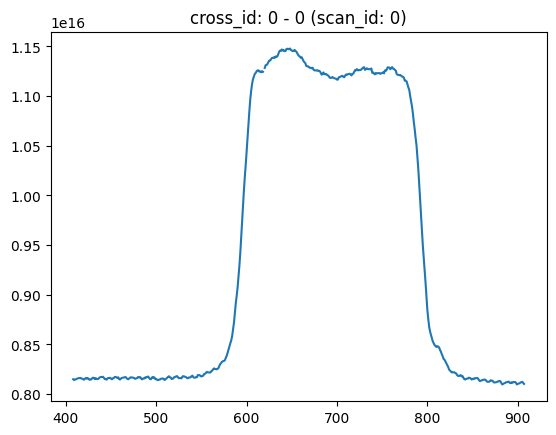

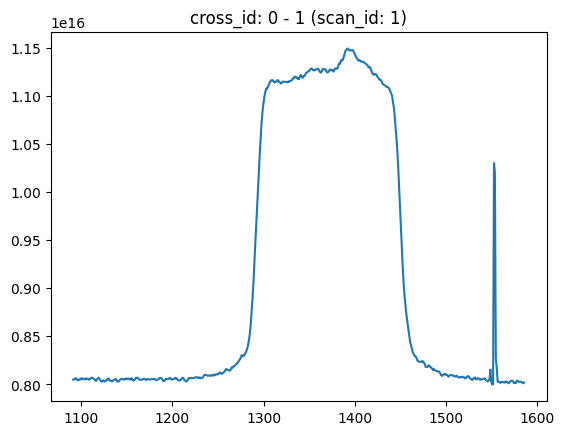

In [100]:
for i in range(scan_num):
    plt.figure()
    planet = planetAnalysis(cross_id=i // 2, axis=i % 2)
    planet.plot()
    #plt.savefig("./20230330_csv/planet_{}/TP/TP_{}_{}.png".format(data_num, data_num, j))

In [87]:
df_scan_copy = planet.df_scan.copy()
df_scan_copy

,time,integrated,lon,lat,lon_cor,lat_cor,offset_az,offset_el,position,offset_x,id
1091,1.725516e+09,8.048512e+15,252.067775,36.137969,249.681118,36.714051,-0.000732,0.933406,b' ',-0.000598,b' '
1092,1.725516e+09,8.051133e+15,252.068051,36.136290,249.681393,36.712372,-0.000784,0.932043,b' ',-0.000641,b' '
1093,1.725516e+09,8.059313e+15,252.068291,36.134735,249.681632,36.710818,-0.000873,0.930805,b' ',-0.000713,b' '
1094,1.725516e+09,8.065759e+15,252.068513,36.133530,249.681853,36.709613,-0.000980,0.929917,b' ',-0.000801,b' '
1095,1.725516e+09,8.050206e+15,252.069096,36.130037,249.682432,36.706121,-0.000743,0.926757,b' ',-0.000607,b' '
...,...,...,...,...,...,...,...,...,...,...,...
1582,1.725516e+09,8.027444e+15,252.232134,34.351693,249.843953,34.928274,0.000755,-0.695681,b'ON ',0.000618,b'0-1 '
1583,1.725516e+09,8.027154e+15,252.232643,34.345861,249.844457,34.922444,0.000936,-0.701196,b'ON ',0.000767,b'0-1 '
1584,1.725516e+09,8.016415e+15,252.232904,34.343004,249.844716,34.919588,0.000870,-0.703736,b'ON ',0.000712,b'0-1 '
1585,1.725516e+09,8.011560e+15,252.233146,34.340111,249.844955,34.916696,0.000784,-0.706312,b'ON ',0.000642,b'0-1 '


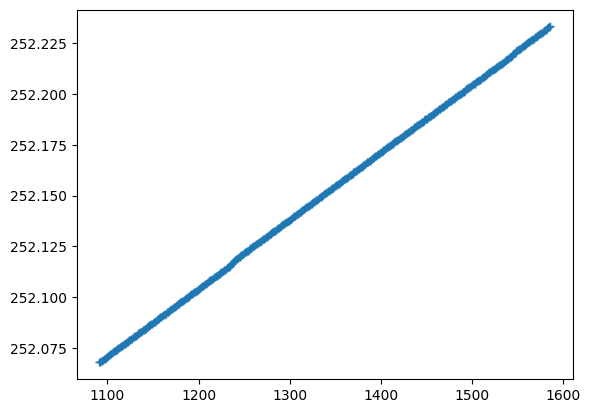

In [89]:
f = plt.figure()
ax = f.add_subplot(111)
# ax.scatter(df_scan_copy["offset_el"], df_scan_copy["integrated"], marker="+")
ax.plot(df_scan_copy["lon"], marker="+", linestyle="None")

In [79]:
print(df_scan_copy['integrated'])

1091    8.048512e+15
1092    8.051133e+15
1093    8.059313e+15
1094    8.065759e+15
1095    8.050206e+15
            ...     
1582    8.027444e+15
1583    8.027154e+15
1584    8.016415e+15
1585    8.011560e+15
1586    8.020522e+15
Name: integrated, Length: 496, dtype: float32


In [80]:
df_scan_copy['integrated'].iloc[:400].max()

1.1493943e+16

In [98]:
data.data[0]

array([1.60412467e+10, 1.60412467e+10, 1.60412467e+10, ...,
       1.25368263e+11, 1.24727525e+11, 1.27191990e+11], dtype=float32)

# スプリアス確認

(12000.0, 12500.0)

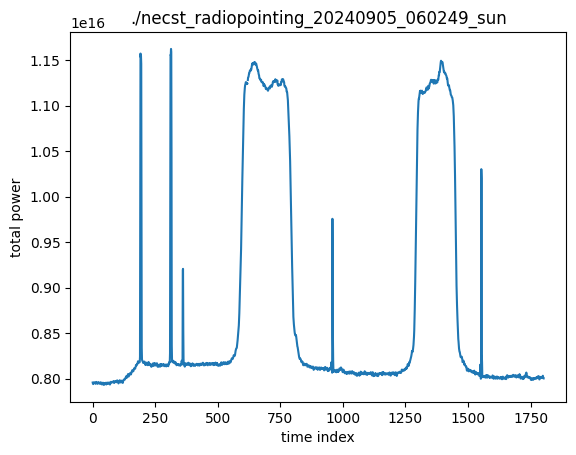

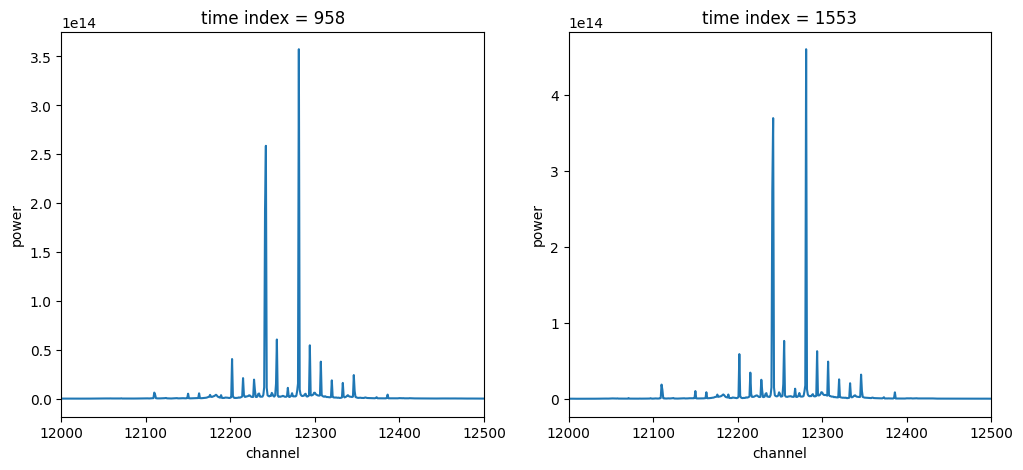

In [140]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(integrated)
ax.title.set_text(RAWDATA_PATH)
ax.set_xlabel("time index")
ax.set_ylabel("total power")
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# ax.plot(integrated)
# ax.set_xlim(950, 960)
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(data.data[958])
ax.title.set_text("time index = 958")
ax.set_xlabel("channel")
ax.set_ylabel("power")
ax.set_xlim(12000, 12500)
ax = fig.add_subplot(1, 2, 2)
ax.plot(data.data[1553])
ax.title.set_text("time index = 1553")
ax.set_xlabel("channel")
ax.set_ylabel("power")
ax.set_xlim(12000, 12500)

## 駆動（座標指示）の確認

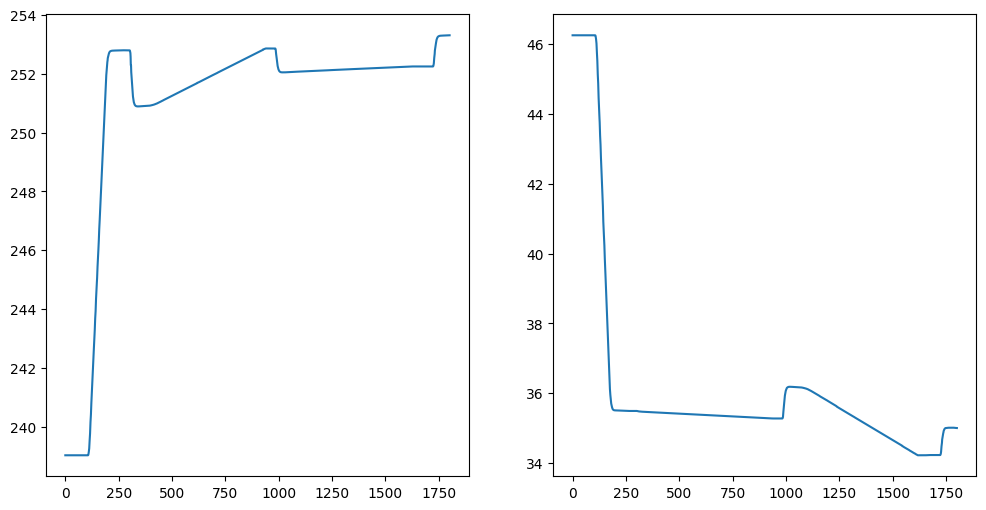

In [81]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(data.lon)
ax = fig.add_subplot(1, 2, 2)
ax.plot(data.lat)

# スキャン解析実行
事前に各 `scan_id` の TP を確認し、天体が受かっていないものは解析時に除外すること<br>
- `cross_id`：何回目のクロススキャンか
- `scan_id`：何回目のスキャンか

|cross_id|scan_id (Az 方向)|scan_id (El 方向)|
|:-:|:-:|:-:|
|0|0|1|
|1|2|3|
|2|4|5|
|...|...|...|
|n|2n|2n+1|

==================== cross 0 - 0 ====================
Index(['time', 'integrated', 'lon', 'lat', 'lon_cor', 'lat_cor', 'offset_az',
       'offset_el', 'position', 'offset_x', 'id'],
      dtype='object')
plot_left: 408
plot_right: 1116
left_min: 169
left_max: 209
right_min: 366
right_max: 406
popt_left = [ 1.41715110e+14 -2.51986756e-01 -2.24660370e-02]
popt_right = [-1.38476202e+14  2.87246823e-01  2.15719149e-02]
d = 63.4681201623402 arcsec
az = 251.92520134256165 deg
el = 35.34228371997587 deg


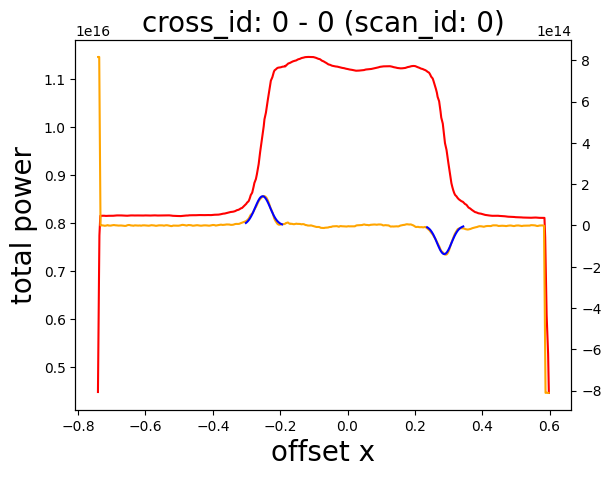

In [83]:
# ======================================================================
BAD_SCAN_ID = [1]  # 解析時に除外する scan_id (0, 1, 2, ...) リスト
# ======================================================================
good_scan_id = [_scan_id for _scan_id in range(scan_num) if _scan_id not in BAD_SCAN_ID]
df_save = pd.DataFrame(columns=["scan_id", "cross_id", "axis", "dx", "dEl", "Az", "El"])
df_save.to_csv(save_path / "d_param.csv", index=False)
for _scan_id in good_scan_id:
    calc_dAz_dEl(cross_id=_scan_id // 2, axis=_scan_id % 2)

# a1, a2, a3, b1, b2, b3, g1 の計算

本来光学ポインティングで行うフィッティング<br>
後の d1, d2 の計算とは必ずどちらかのみを行い、両方同時に行わないこと
- a1：Az-El の非直交性
- a2：光学軸と El 軸の非直交性
- a3：Az エンコーダのオフセット
- b1：天頂からの Az 軸の傾き (南北方向)
- b2：天頂からの El 軸の傾き (東西方向)
- b3：El エンコーダのオフセット
- g1：重力の影響によるオフセット

## 定数や関数の定義
- 以下の定数は再設定したい場合のみ指定すること

In [60]:
# ======================================================================
DATETIME = "20240905-0913"  # データファイル名の日時部分 "YYYYMMDD_HHMMSS"
# ======================================================================
SAVE_PATH = f"./{DATETIME}_sun"  # 解析結果の保存先
# ======================================================================
print(f"Analysis target data is {SAVE_PATH!r}.")
save_path = Path(SAVE_PATH)
# ======================================================================

Analysis target data is './20240905-0913_sun'.


- 以降は設定不要

In [61]:
# RAWDATA_PATH = "./necst_radiopointing_20230330_121827_moon"
# dir_save = f"./1p85m_analy/20230330_csv/{PLANET}_{data_num}"

# date = "20240525_1"
# dbname = "necst_opticalpointing_20240525_113626"

data_dir = save_path
# pic_dir = "pics" + "/" + date +"/"
kisa_file = rawdata_path / "pointing_param.toml"
figs = save_path

In [62]:
def write_param(filepath, model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2, unit="deg"):
    with open(filepath, mode="w") as file:
        param = (
            f'[metadata]\n'
            f'model = "{model}"\n'
            f'\n'
            f'[pointing_params]\n'
            f'"a1[{unit}]" = {a1.to(unit).value}\n'
            f'"a2[{unit}]" = {a2.to(unit).value}\n'
            f'"a3[{unit}]" = {a3.to(unit).value}\n'
            f'"b1[{unit}]" = {b1.to(unit).value}\n'
            f'"b2[{unit}]" = {b2.to(unit).value}\n'
            f'"b3[{unit}]" = {b3.to(unit).value}\n'
            f'g1 = {g1}\n'
            f'"c1[{unit}]" = {c1.to(unit).value}\n'
            f'"c2[{unit}]" = {c2.to(unit).value}\n'
            f'"d1[{unit}]" = {d1.to(unit).value}\n'
            f'"d2[{unit}]" = {d2.to(unit).value}\n'
            f'"e1[{unit}]" = {e1.to(unit).value}\n'
            f'"e2[{unit}]" = {e2.to(unit).value}\n'
        )
        file.write(param)
    print(f"======= {filepath!r} =======")
    print(param)

In [63]:
param_before = Parameters.from_file(kisa_file)
def apply_kisa():
        if param_before.model != "omu1p85m":
                raise NotImplementedError(f"This analysis is only for model omu1p85m, not {param_before.model}.")
        # fkisa = open(kisa_file,"r")
        # kisa = fkisa.readlines()
        param_delta = Parameters.from_file(data_dir / "pointing_param_delta.toml")
        # fdkisa = open(f"{data_dir}/pointing_param_delta", "r")
        # dkisa = fdkisa.readlines()
        a1 = param_before.a1 + param_delta.a1
        a2 = param_before.a2 + param_delta.a2
        a3 = param_before.a3 + param_delta.a3
        b1 = param_before.b1 + param_delta.b1
        b2 = param_before.b2 + param_delta.b2
        b3 = param_before.b3 + param_delta.b3
        g1 = param_before.g1 + param_delta.g1
        c1 = param_before.c1 + param_delta.c1
        c2 = param_before.c2 + param_delta.c2
        d1 = param_before.d1 + param_delta.d1
        d2 = param_before.d2 + param_delta.d2
        e1 = param_before.e1 + param_delta.e1
        e2 = param_before.e2 + param_delta.e2
        # fkisa.close()

        # old_kisa_file = f"{data_dir}/pointing_param_before.toml"
        # shutil.copy(kisa_file, old_kisa_file)
        # print("``pointing_param_before.toml`` was created.")

        write_param(data_dir / "pointing_param_after.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2)
        # nkisa = open(kisa_file,"w")
        # param_new = (f'[metadata]\n'
        #              f'model = "{param.model}"\n'
        #              f'\n'
        #              f'[pointing_params]\n'
        #              f'"a1[deg]" = {a1.to("deg").value}\n'
        #              f'"a2[deg]" = {a2.to("deg").value}\n'
        #              f'"a3[deg]" = {a3.to("deg").value}\n'
        #              f'"b1[deg]" = {b1.to("deg").value}\n'
        #              f'"b2[deg]" = {b2.to("deg").value}\n'
        #              f'"b3[deg]" = {b3.to("deg").value}\n'
        #              f'g1 = {g1}\n'
        #              f'"c1[deg]" = {c1.to("deg").value}\n'
        #              f'"c2[deg]" = {c2.to("deg").value}\n'
        #              f'"d1[deg]" = {d1.to("deg").value}\n'
        #              f'"d2[deg]" = {d2.to("deg").value}\n'
        #              f'"e1[deg]" = {e1.to("deg").value}\n'
        #              f'"e2[deg]" = {e2.to("deg").value}\n')
        # nkisa.write(param_new)
        # nkisa.write(str(a1)+"\n")
        # nkisa.write(str(a2)+"\n")
        # nkisa.write(str(a3)+"\n")
        # nkisa.write(str(b1)+"\n")
        # nkisa.write(str(b2)+"\n")
        # nkisa.write(str(b3)+"\n")
        # nkisa.write(str(g1)+"\n")
        # nkisa.write(str(c1)+"\n")
        # nkisa.write(str(c2)+"\n")
        # nkisa.write(str(d1)+"\n")
        # nkisa.write(str(d2)+"\n")    
        # nkisa.write(str(e1)+"\n")
        # nkisa.write(str(e2)+"\n")
        # nkisa.close()

        # new_kisa_file = data_dir + "pointing_param_after.toml"
      #  shutil.copy(f"{data_dir}/pointing_param_after.toml", kisa_file)
       # print("``pointing_param_after.toml`` was created and pointing_param was updated.")
       # print("Data location : " + data_dir)
       # print("======= ``pointing_param_delta.toml`` =======")
       # print(param_delta)
        # print(a1)
        # print(a2)
        # print(a3)
        # print(b1)
        # print(b2)
        # print(b3)
        # print(g1)
        # print(c1)
        # print(c2)
        # print(d1)
        # print(d2)
        # print(e1)
        # print(e2)

## ここから実処理

In [64]:
csv = pd.read_csv(save_path / "d_param.csv")
csv

,scan_id,cross_id,axis,dx,dEl,Az,El
0,0,5000,0,55.100185,NaN,161.142451,58.527802
1,1,5000,1,NaN,21.159185,161.690518,58.613188
2,0,5100,0,59.737606,NaN,198.642713,59.190978
3,1,5100,1,NaN,-3.884745,199.233757,59.119431
4,1,5200,1,NaN,6.780025,218.424935,55.095677
...,...,...,...,...,...,...,...
170,15,13007,1,NaN,59.612459,128.465680,43.365814
171,16,13008,0,36.961193,NaN,128.763234,43.550728
172,17,13008,1,NaN,65.103473,129.146527,43.786272
173,18,13009,0,36.225030,NaN,129.459292,43.976278


In [65]:
csv_az = csv.dropna(subset=["dx"])
csv_el = csv.dropna(subset=["dEl"])
csv_union = pd.DataFrame(columns=["cross_id", "dx", "dEl", "Az", "El"])
for _cross_id in np.unique(csv.cross_id):
    if _cross_id not in csv_az.cross_id.values or _cross_id not in csv_el.cross_id.values:
        continue
    dx = csv_az[csv_az.cross_id == _cross_id].dx.values[0]
    dEl = csv_el[csv_el.cross_id == _cross_id].dEl.values[0]
    Az = (csv_az[csv_az.cross_id == _cross_id].Az.values[0] + csv_el[csv_el.cross_id == _cross_id].Az.values[0]) / 2
    El = (csv_az[csv_az.cross_id == _cross_id].El.values[0] + csv_el[csv_el.cross_id == _cross_id].El.values[0]) / 2
    csv_union = csv_union.append({"cross_id": _cross_id, "dx": dx, "dEl": dEl, "Az": Az, "El": El}, ignore_index=True)
csv_union

/var/folders/kg/9l2rd83d59ngv9_pltms1_nm0000gn/T/ipykernel_25523/2300965716.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  csv_union = csv_union.append({"cross_id": _cross_id, "dx": dx, "dEl": dEl, "Az": Az, "El": El}, ignore_index=True)
/var/folders/kg/9l2rd83d59ngv9_pltms1_nm0000gn/T/ipykernel_25523/2300965716.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  csv_union = csv_union.append({"cross_id": _cross_id, "dx": dx, "dEl": dEl, "Az": Az, "El": El}, ignore_index=True)
/var/folders/kg/9l2rd83d59ngv9_pltms1_nm0000gn/T/ipykernel_25523/2300965716.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  csv_union = csv_union.append({"cross_id": _cross_id, "dx": dx, "dEl": dEl, "Az": Az, "El": El}, ignore_index=True)
/

,cross_id,dx,dEl,Az,El
0,5000.0,55.100185,21.159185,161.416485,58.570495
1,5100.0,59.737606,-3.884745,198.938235,59.155204
2,5300.0,60.956443,23.830307,237.672946,46.460340
3,6000.0,33.854476,64.623640,121.313774,42.111848
4,6100.0,52.290940,40.278917,138.309334,51.808878
...,...,...,...,...,...
68,13005.0,36.391461,50.742703,127.114572,42.502914
69,13006.0,32.332330,62.217898,127.714683,42.890766
70,13007.0,29.137274,59.612459,128.313450,43.270272
71,13008.0,36.961193,65.103473,128.954881,43.668500


In [66]:
# rms の計算
dx_sigma = np.nanstd(csv["dx"])
dy_sigma = np.nanstd(csv["dEl"])
d_sigma = np.sqrt(dx_sigma**2 + dy_sigma**2)

print(f"sigma = {d_sigma:.2f} arcsec")

sigma = 24.73 arcsec


In [67]:
def f_az2(X, a1, a2, a3, b1, b2, b3, g1):
    _az, _el = X
    az = _az * np.pi / 180
    el = _el * np.pi / 180
    # return np.cos(el) * ((a1 * np.tan(el)) + (a2 / np.cos(el)) + a3 + (b1 * np.sin(az) * np.sin(el) - b2 * np.cos(az) * np.sin(el)) / np.cos(el))
    return a1 * np.sin(el) + a2 + a3 * np.cos(el) + b1 * np.sin(az) * np.sin(el) + b2 * np.cos(az) * np.sin(el) 

def f_el2(X, a1, a2, a3, b1, b2, b3, g1):
    _az, _el = X
    az = _az * np.pi / 180
    return b1 * np.cos(az) + b2 * np.sin(az) + b3 + g1 * _el

def eval_func(p, az, el, dx):
    results_dx = f_az2([az, el], *p)
    return (dx - results_dx) ** 2

def eval_func2(p, az, el, dy):
    results_dy = f_el2([az, el],*p)
    return (dy - results_dy) ** 2

def eval_func3(p, az, el, dx, dy):
    results_dx = f_az2([az, el], *p)
    results_dy = f_el2([az, el], *p)
    return (dx - results_dx) ** 2 + (dy - results_dy) ** 2

In [68]:
pp1 = optimize.least_squares(eval_func, x0=[0,0,0,0,0,0,0], args=(csv_az["Az"], csv_az["El"], csv_az["dx"]))
pp2 = optimize.least_squares(eval_func2, x0=[0,0,0,0,0,0,0], args=(csv_el["Az"], csv_el["El"], csv_el["dEl"]))
print(pp1.x)
print(pp2.x)

[-235.92670761  644.03282387 -525.42955005  -14.21479523  131.62371888
    0.            0.        ]
[  0.         347.33267305  65.82665084  53.80540735  26.87410199
 114.37530092  -0.92397521]


In [69]:
pp = list(pp1.x[0:3])+list(pp2.x[3:7])
print(pp)

[-235.92670761294994, 644.0328238650756, -525.4295500516431, 53.805407347286774, 26.87410199414666, 114.37530092397009, -0.9239752085576967]


In [70]:
pp3 = optimize.least_squares(eval_func3, x0=pp, args=(csv_union["Az"], csv_union["El"], csv_union["dx"], csv_union["dEl"]))
print(pp3.x)
print(pp3.x / 3600)

[ -86.4237804   225.52456599 -149.13021959  -19.5148763    19.66380787
  162.01607146   -2.98559662]
[-0.02400661  0.06264571 -0.04142506 -0.0054208   0.00546217  0.04500446
 -0.00082933]


In [71]:
bestfit_dx = f_az2([csv["Az"],csv["El"]], *pp3.x)
bestfit_dy = f_el2([csv["Az"],csv["El"]], *pp3.x)

# debug
# bestfit_dx = f_az2([csv["Az"],csv["El"]], *pp1.x)
# bestfit_dy = f_el2([csv["Az"],csv["El"]], *pp2.x)

In [72]:
error_dx = csv["dx"] - bestfit_dx
error_dy = csv["dEl"] - bestfit_dy

bestfit_dx_sigma = np.nanstd(error_dx)
bestfit_dy_sigma = np.nanstd(error_dy)
bestfit_d_sigma = np.sqrt(bestfit_dx_sigma**2 + bestfit_dy_sigma**2)

print(f"bestfit_sigma = {bestfit_d_sigma:.2f} arcsec")

bestfit_sigma = 8.95 arcsec


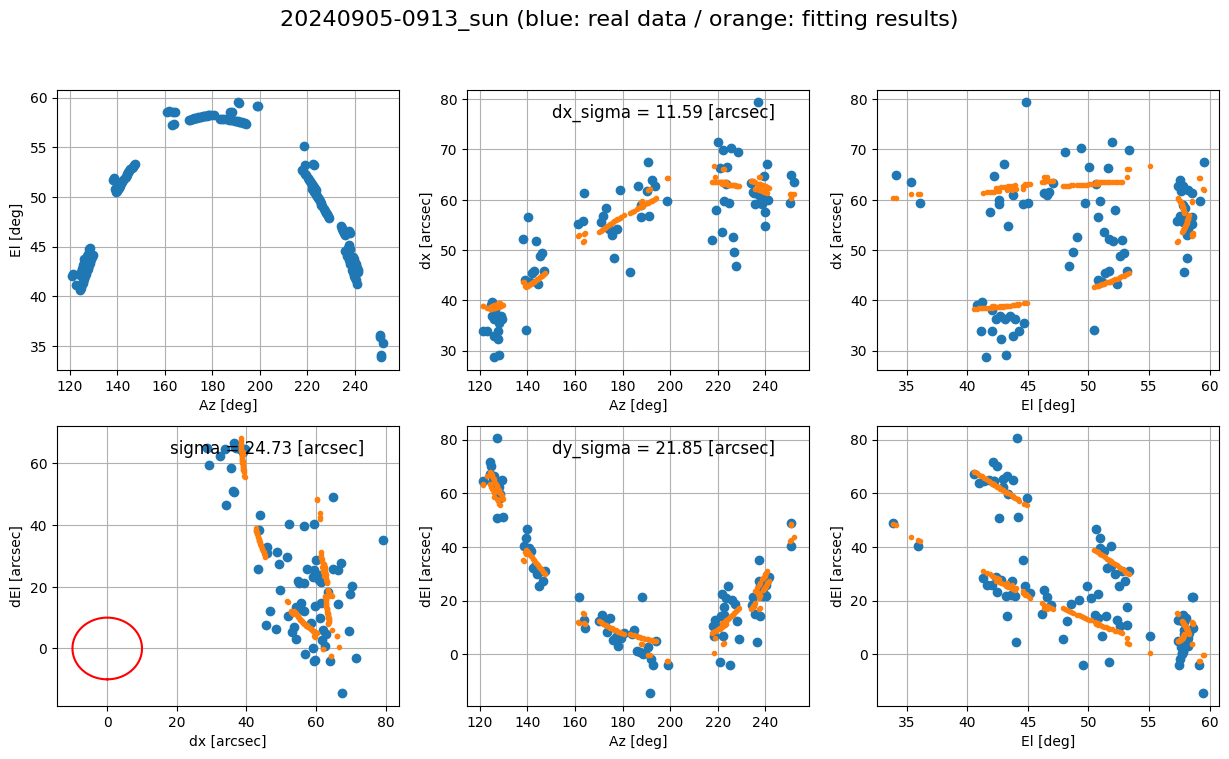

In [78]:
fig = plt.figure(figsize=[15,8])
ax = [fig.add_subplot(2,3,i) for i in range(1,7)]
[_ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False)) for _ax in ax]
[_ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False)) for _ax in ax]

ax[0].plot(csv['Az'], csv['El'], 'o')
ax[0].set_xlabel('Az [deg]')
ax[0].set_ylabel('El [deg]')

ax[1].plot(csv['Az'], csv['dx'], 'o')
ind1=np.argsort(csv['Az'])
ax[1].plot(csv['Az'][ind1], bestfit_dx[ind1], '.')
ax[1].set_xlabel('Az [deg]')
ax[1].set_ylabel('dx [arcsec]')
ax[1].text(0.9, 0.95, 'dx_sigma = %0.2f [arcsec]'%dx_sigma, size=12, ha='right', va='top', transform=ax[1].transAxes,)

ax[2].plot(csv['El'], csv['dx'], 'o')
ind2=np.argsort(csv['El'])
ax[2].plot(csv['El'][ind2], bestfit_dx[ind2], '.')
ax[2].set_xlabel('El [deg]')
ax[2].set_ylabel('dx [arcsec]')

ax[3].plot(csv_union['dx'], csv_union['dEl'], 'o')
ax[3].plot(bestfit_dx, bestfit_dy, '.')
ax[3].set_xlabel('dx [arcsec]')
ax[3].set_ylabel('dEl [arcsec]')
ax[3].text(0.9, 0.95, 'sigma = %0.2f [arcsec]'%d_sigma, size=12, ha='right', va='top', transform=ax[3].transAxes,)

X, Y = [], []
for num in np.linspace(-180,180,360):
    r = 10. #[arcsec]
    X.append(r * math.sin(math.radians(num)))
    Y.append(r * math.cos(math.radians(num)))
ax[3].plot(X, Y,"r")

ax[4].plot(csv['Az'], csv['dEl'], 'o')
ax[4].plot(csv['Az'][ind1], bestfit_dy[ind1], '.')
ax[4].set_xlabel('Az [deg]')
ax[4].set_ylabel('dEl [arcsec]')
ax[4].text(0.9, 0.95, 'dy_sigma = %0.2f [arcsec]'%dy_sigma, size=12, ha='right', va='top', transform=ax[4].transAxes,)

ax[5].plot(csv['El'], csv['dEl'], 'o')
ax[5].plot(csv['El'][ind2], bestfit_dy[ind2], '.')
ax[5].set_xlabel('El [deg]')
ax[5].set_ylabel('dEl [arcsec]')

[a.grid(True) for a in ax]

fig.suptitle(f"{str(save_path.name)} (blue: real data / orange: fitting results)", fontsize=16)
fig.savefig(figs / "pointing_results.png")

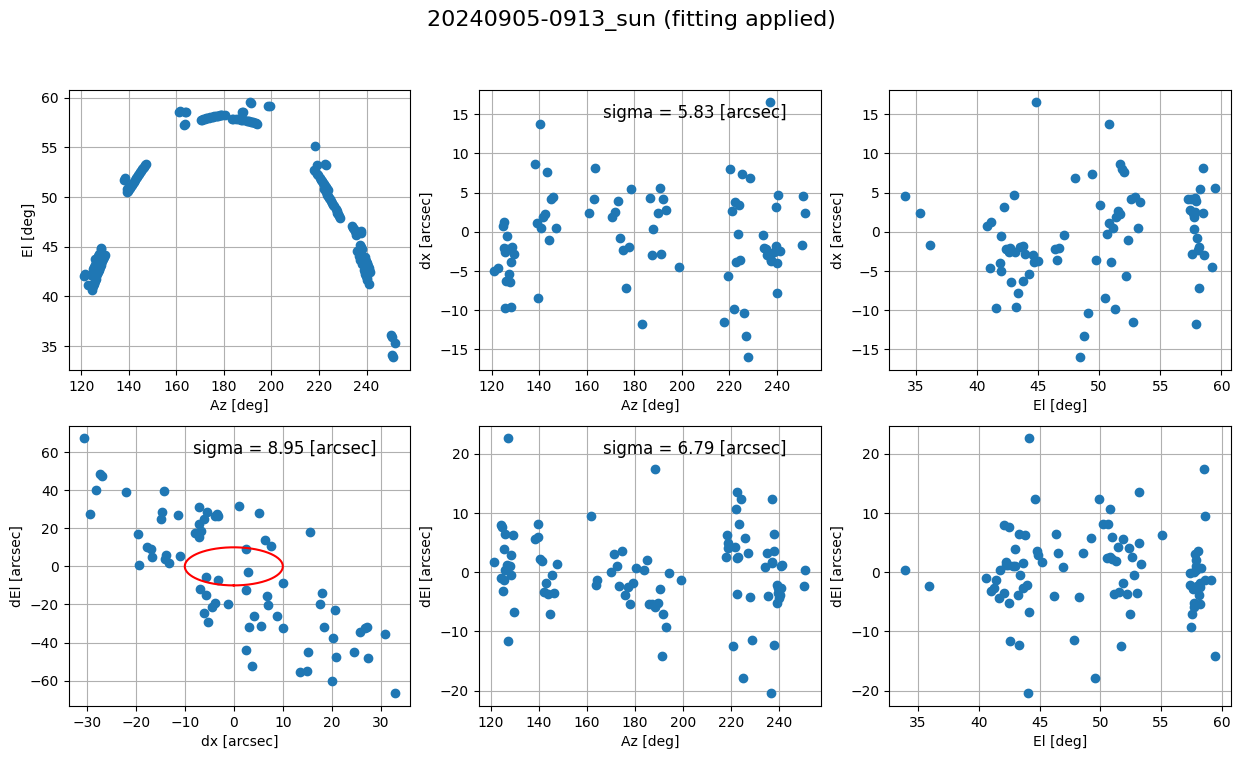

In [74]:
fig = plt.figure(figsize=[15,8])
ax = [fig.add_subplot(2,3,i) for i in range(1,7)]

ax[0].plot(csv['Az'], csv['El'], 'o')
ax[0].set_xlabel('Az [deg]')
ax[0].set_ylabel('El [deg]')

ax[1].plot(csv['Az'], csv['dx']-bestfit_dx, 'o')
ax[1].set_xlabel('Az [deg]')
ax[1].set_ylabel('dx [arcsec]')
ax[1].text(0.9, 0.95, 'sigma = %0.2f [arcsec]'%bestfit_dx_sigma, size=12, ha='right', va='top', transform=ax[1].transAxes,)

ax[2].plot(csv['El'], csv['dx']-bestfit_dx, 'o')
ax[2].set_xlabel('El [deg]')
ax[2].set_ylabel('dx [arcsec]')

ax[3].plot(csv_union['dx']-bestfit_dx, csv_union['dEl']-bestfit_dy, 'o')
ax[3].set_xlabel('dx [arcsec]')
ax[3].set_ylabel('dEl [arcsec]')
ax[3].text(0.9, 0.95, 'sigma = %0.2f [arcsec]'%bestfit_d_sigma, size=12, ha='right', va='top', transform=ax[3].transAxes,)

X, Y = [], []
for num in np.linspace(-180,180,360):
    r = 10. #[arcsec]
    X.append(r * math.sin(math.radians(num)))
    Y.append(r * math.cos(math.radians(num)))
ax[3].plot(X, Y,"r")

ax[4].plot(csv['Az'], csv['dEl']-bestfit_dy, 'o')
ax[4].set_xlabel('Az [deg]')
ax[4].set_ylabel('dEl [arcsec]')
ax[4].text(0.9, 0.95, 'sigma = %0.2f [arcsec]'%bestfit_dy_sigma, size=12, ha='right', va='top', transform=ax[4].transAxes,)

ax[5].plot(csv['El'], csv['dEl']-bestfit_dy, 'o')
ax[5].set_xlabel('El [deg]')
ax[5].set_ylabel('dEl [arcsec]')

[a.grid(True) for a in ax]

fig.suptitle(f"{str(save_path.name)} (fitting applied)", fontsize=16)
fig.savefig(figs / "pointing_fitting_applied.png")

In [75]:
# a1, a2, a3, b1, b2, b3, g1 の変化量を決定して出力
dkisa_array = pp3.x.T/3600 * -1  # 符号の反転を直す
a1 = dkisa_array[0] * u.deg
a2 = dkisa_array[1] * u.deg
a3 = dkisa_array[2] * u.deg
b1 = dkisa_array[3] * u.deg
b2 = dkisa_array[4] * u.deg
b3 = dkisa_array[5] * u.deg
g1 = dkisa_array[6]
c1 = 0.0 * u.deg
c2 = 0.0 * u.deg
d1 = 0.0 * u.deg
d2 = 0.0 * u.deg
e1 = 0.0 * u.deg
e2 = 0.0 * u.deg
write_param(data_dir / "pointing_param_delta.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2)
# np.savetxt(f"{data_dir}/pointing_param_delta.toml", dkisa_array)

======= PosixPath('20240905-0913_sun/pointing_param_delta.toml') =======
[metadata]
model = "omu1p85m"

[pointing_params]
"a1[deg]" = 0.024006605665979126
"a2[deg]" = -0.06264571277595825
"a3[deg]" = 0.041425060997085844
"b1[deg]" = 0.005420798971433221
"b2[deg]" = -0.00546216885337624
"b3[deg]" = -0.045004464293314256
g1 = 0.0008293323946431923
"c1[deg]" = 0.0
"c2[deg]" = 0.0
"d1[deg]" = 0.0
"d2[deg]" = 0.0
"e1[deg]" = 0.0
"e2[deg]" = 0.0



In [76]:
# arcsec でも一応出力
write_param(data_dir / "pointing_param_delta_arcsec.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2, unit="arcsec")
# dkisa_array = pp3.x.T * -1  # 符号の反転を直す
# a1 = dkisa_array[0] * u.arcsec
# a2 = dkisa_array[1] * u.arcsec
# a3 = dkisa_array[2] * u.arcsec
# b1 = dkisa_array[3] * u.arcsec
# b2 = dkisa_array[4] * u.arcsec
# b3 = dkisa_array[5] * u.arcsec
# g1 = dkisa_array[6]/3600
# c1 = 0.0 * u.deg
# c2 = 0.0 * u.deg
# d1 = 0.0 * u.deg
# d2 = 0.0 * u.deg
# e1 = 0.0 * u.deg
# e2 = 0.0 * u.deg
# write_param(f"{data_dir}/pointing_param_delta_arcsec.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2)
# np.savetxt(f"{data_dir}/pointing_param_delta.toml", dkisa_array)

======= PosixPath('20240905-0913_sun/pointing_param_delta_arcsec.toml') =======
[metadata]
model = "omu1p85m"

[pointing_params]
"a1[arcsec]" = 86.42378039752485
"a2[arcsec]" = -225.5245659934497
"a3[arcsec]" = 149.13021958950904
"b1[arcsec]" = 19.514876297159596
"b2[arcsec]" = -19.663807872154464
"b3[arcsec]" = -162.01607145593132
g1 = 0.0008293323946431923
"c1[arcsec]" = 0.0
"c2[arcsec]" = 0.0
"d1[arcsec]" = 0.0
"d2[arcsec]" = 0.0
"e1[arcsec]" = 0.0
"e2[arcsec]" = 0.0



In [77]:
# 変化後の器差を出力
apply_kisa() 

======= PosixPath('20240905-0913_sun/pointing_param_after.toml') =======
[metadata]
model = "omu1p85m"

[pointing_params]
"a1[deg]" = 0.039981430502322494
"a2[deg]" = -0.03334270740566954
"a3[deg]" = 2.504394868520747
"b1[deg]" = 0.014880384893749973
"b2[deg]" = -0.009637621740693016
"b3[deg]" = -0.7674884541100614
g1 = 0.0011256347503924785
"c1[deg]" = 0.0
"c2[deg]" = 0.0
"d1[deg]" = -0.09385801389632961
"d2[deg]" = 0.13489303753715953
"e1[deg]" = 0.0
"e2[deg]" = 0.0



# d1, d2 の計算
本来の電波ポインティングで行う器差補正<br>
前の a1, a2, a3, b1, b2, b3, g1 の計算とは必ずどちらかのみを行い、両方同時に行わないこと
- d1：電波光学系とガイド光学望遠鏡の Az 方向のオフセット (dAz の単純平均)
- d2：電波光学系とガイド光学望遠鏡の El 方向のオフセット (dEl の単純平均)

c1, c2, e1, e2 はずっと 0 で変更されていない？
- c1：光学系の軸とホーン位置の東西方向のズレ
- c2：光学系の軸とホーン位置の南北方向のズレ
- e1：情報なし
- e2：情報なし

In [290]:
# NaNを無視して平均を計算
mean_dAz = csv_az["dAz"].mean() * u.arcsec
mean_dEl = csv_el["dEl"].mean() * u.arcsec
print(f"mean_dAz = {mean_dAz}")
print(f"mean_dEl = {mean_dEl}")

mean_dAz = -197.19523637421992 arcsec
mean_dEl = -28.560737350694406 arcsec


In [292]:
# d1, d2 の変化量を決定して出力
a1 = 0.0 * u.deg
a2 = 0.0 * u.deg
a3 = 0.0 * u.deg
b1 = 0.0 * u.deg
b2 = 0.0 * u.deg
b3 = 0.0 * u.deg
g1 = 0.0
c1 = 0.0 * u.deg
c2 = 0.0 * u.deg
d1 = mean_dAz.to(u.deg)
d2 = mean_dEl.to(u.deg)
e1 = 0.0 * u.deg
e2 = 0.0 * u.deg
# write_param(data_dir / "pointing_param_delta.toml", param_before.model, a1, a2, a3, b1, b2, b3, g1, c1, c2, d1, d2, e1, e2)

======= PosixPath('1p85m_analy/20230330_csv/moon_121827/pointing_param_delta.toml') =======
[metadata]
model = "omu1p85m"

[pointing_params]
"a1[deg]" = 0.0
"a2[deg]" = 0.0
"a3[deg]" = 0.0
"b1[deg]" = 0.0
"b2[deg]" = 0.0
"b3[deg]" = 0.0
g1 = 0.0
"c1[deg]" = 0.0
"c2[deg]" = 0.0
"d1[deg]" = -0.05477645454839442
"d2[deg]" = -0.007933538152970668
"e1[deg]" = 0.0
"e2[deg]" = 0.0



In [293]:
# 変化後の器差を出力
# apply_kisa()

======= '1p85m_analy/20230330_csv/moon_121827/pointing_param_after.toml' =======
[metadata]
model = "omu1p85m"

[pointing_params]
"a1[deg]" = 0.015974824836343368
"a2[deg]" = 0.02930300537028871
"a3[deg]" = 2.6
"b1[deg]" = 0.009459585922316752
"b2[deg]" = -0.004175452887316775
"b3[deg]" = -0.7224839898167471
g1 = 0.00029630235574928623
"c1[deg]" = 0.0
"c2[deg]" = 0.0
"d1[deg]" = -0.14863446844472403
"d2[deg]" = 0.12695949938418888
"e1[deg]" = 0.0
"e2[deg]" = 0.0

